In [1]:
# preprocessing
import pandas as pd
import re
from nltk.corpus import stopwords

# method
from collections import Counter
from wordcloud import WordCloud
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pyLDAvis
import pyLDAvis.gensim_models
from textblob import TextBlob

#visualization
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/var/folders/c_/6jt_vlf55f91p67q18x96hlr0000gn/T/ipykernel_9273/1928327437.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
tweets = pd.read_csv('tweets.csv')

In [3]:
# Convert 'time' column to datetime format
tweets["time"] = pd.to_datetime(tweets["time"], format="%Y-%m-%dT%H:%M:%S")

tweets["date"] = tweets["time"].dt.strftime("%Y-%m-%d")

In [4]:
# Define list of features to keep
FEATURES = ['date', 'text', 'retweet_count', 'favorite_count', 'handle']

# Select only the specified features from the 'tweets' DataFrame
tweets = tweets[FEATURES]

In [5]:
def preprocess_text(text):
    """
    Preprocesses the input text by removing punctuation, converting to lowercase,
    and removing stop words.
    
    Args:
    - text: A string containing each row of text data
    
    Returns:
    - preprocessed_no_stopwords: A list of preprocessed words with stop words removed
    """
    
    # Remove punctuation and convert to lowercase
    preprocessed_text = re.sub(r'[^\w\s]', '', text).lower()
    
    # Split the text into words
    preprocessed_words = preprocessed_text.split()

    # Remove stop words
    stop_words = set(stopwords.words('english'))

    preprocessed_no_stopwords = [word for word in preprocessed_words if word not in stop_words]

    # Remove meaningless but repeadly appeared words
    unwanted_words = ['amp', 'http', 'https', 'realdonaldtrump', 'trump', 'donald', 'clinton', 'hillary', 'will', 'say', 'said', 'let', 'now', 'go']
    filtered_words = [word for word in preprocessed_no_stopwords if word not in unwanted_words]
    
    return filtered_words

tweets['preprocessed_text'] = tweets['text'].apply(preprocess_text)

### The LDAvis visualization arc

In [6]:
preprocessed_text_all = [item for sublist in tweets['preprocessed_text'] for item in sublist]

In [7]:
# Tokenize the text
tokenized_text = [text.split() for text in preprocessed_text_all]

# Create dictionary
dictionary = Dictionary(tokenized_text)

# Filter out tokens that appear in less than 5 documents or more than 50% of the documents
dictionary.filter_extremes(no_above=0.5)

# Convert text to bag-of-words format
corpus = [dictionary.doc2bow(text) for text in tokenized_text]

# Train LDA model
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=5, 
    random_state=699,
#    update_every=1,
#    chunksize=100,
#    alpha='auto',
#    passes=15,
#    decay=0.5,
#    per_word_topics=True
)

In [8]:
# Generate Topic Distance Visualization 
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)

/Users/yonniechan/opt/anaconda3/envs/env699/lib/python3.9/site-packages/pyLDAvis/_prepare.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/yonniechan/opt/anaconda3/envs/env699/lib/python3.9/site-packages/pyLDAvis/_prepare.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https:/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.140460  0.364512       1        1  20.373708
1      0.041835 -0.048742       2        1  20.003711
0     -0.392639  0.018730       3        1  19.946817
4      0.152622 -0.237071       4        1  19.899381
2      0.057722 -0.097429       5        1  19.776383, topic_info=           Term        Freq       Total Category  logprob  loglift
90        great  852.000000  852.000000  Default  30.0000  30.0000
96        thank  811.000000  811.000000  Default  29.0000  29.0000
1746  trump2016  627.000000  627.000000  Default  28.0000  28.0000
1863       cruz  491.000000  491.000000  Default  27.0000  27.0000
57       people  466.000000  466.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
2103     canada   60.438956   61.303054   Topic5  -5.0614   1.6065
403         gun   53.254609   54.032236   Topic5  -5.1880   1.6062
2106    jebbush   54.488052   55.352139   Topic5  -5.1651   1.6049
2121   iacaucus   72.306820   75.417663   Topic5  -4.8822   1.5786
2117       fitn   68.497173   74.785612   Topic5  -4.9363   1.5328

[185 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
753       5  0.986272     2016
752       2  0.988054        4
1648      1  0.992720      ads
325       5  0.981572  allowed
724       4  0.989953  amazing
...     ...       ...      ...
280       3  0.997672      wow
740       2  0.991701    wrong
963       4  0.995250     year
239       3  0.989375    years
938       3  0.989754     york

[163 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 5, 3])

### Comparison of Trump and Clinton's word frequency

In [9]:
# Filter tweets data to separate those authored by Donald Trump and Hillary Clinton
trump = tweets[tweets['handle'] == 'realDonaldTrump']  # Select tweets from Donald Trump
clinton = tweets[tweets['handle'] == 'HillaryClinton']  # Select tweets from Hillary Clinton

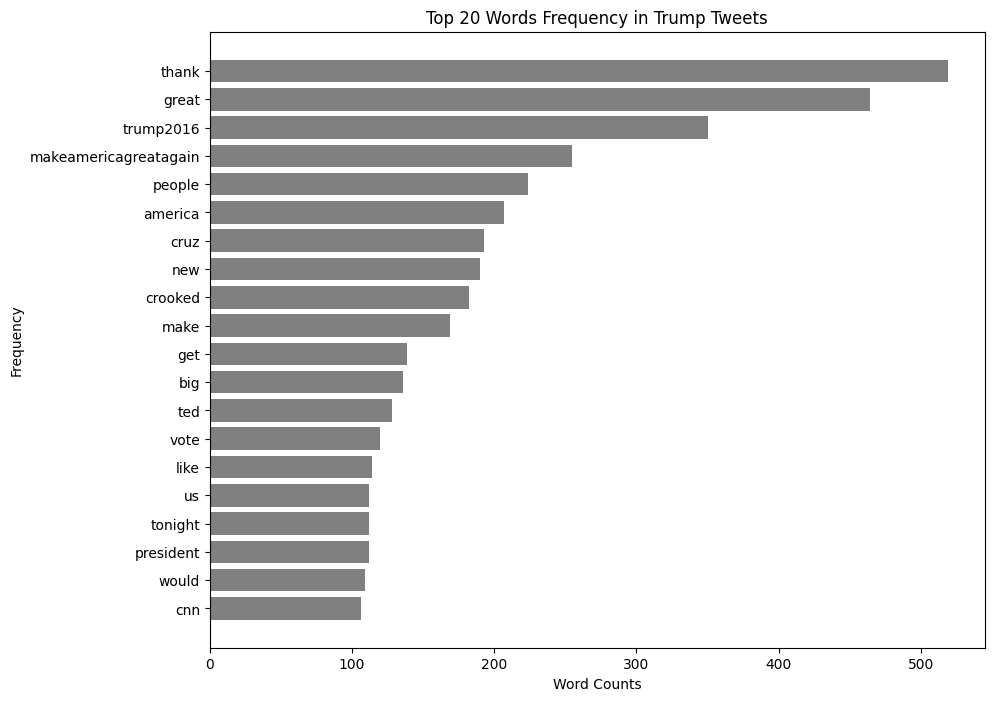

In [10]:
trump_all = [item for sublist in trump['preprocessed_text'] for item in sublist]
trump_freq20 = dict(Counter(trump_all).most_common(20))

# Extract data from trump_freq
words = list(trump_freq20.keys())
frequencies = list(trump_freq20.values())

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='grey')
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Top 20 Words Frequency in Trump Tweets')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

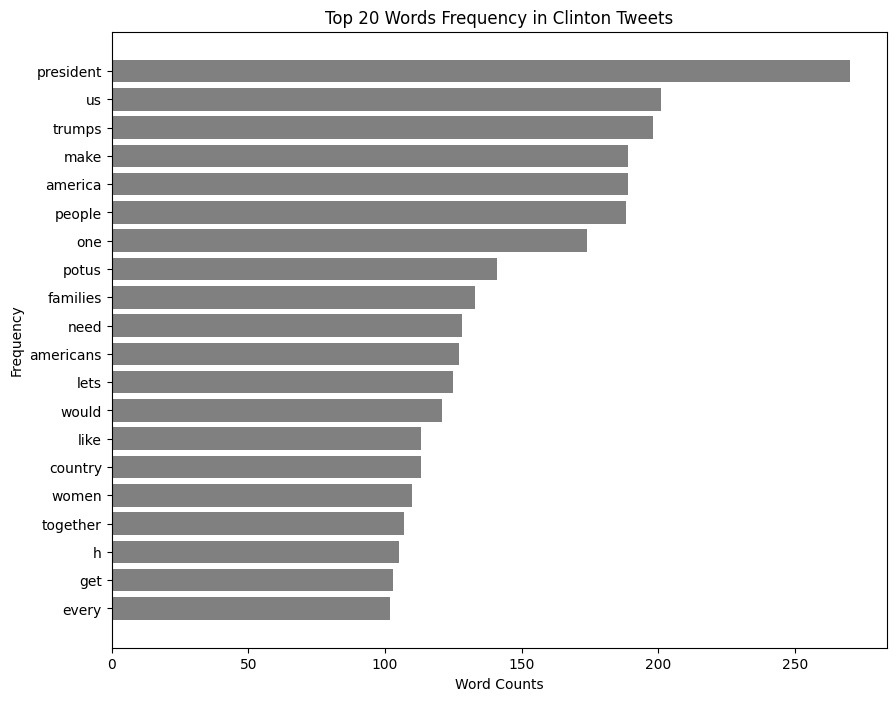

In [11]:
clinton_all = [item for sublist in clinton['preprocessed_text'] for item in sublist]
clinton_freq20 = dict(Counter(clinton_all).most_common(20))

# Extract data from clinton_freq
words = list(clinton_freq20.keys())
frequencies = list(clinton_freq20.values())

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(words, frequencies, color='grey')
plt.xlabel('Word Counts')
plt.ylabel('Frequency')
plt.title('Top 20 Words Frequency in Clinton Tweets')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

### Word cloud of Trump and Clinton’s word frequency

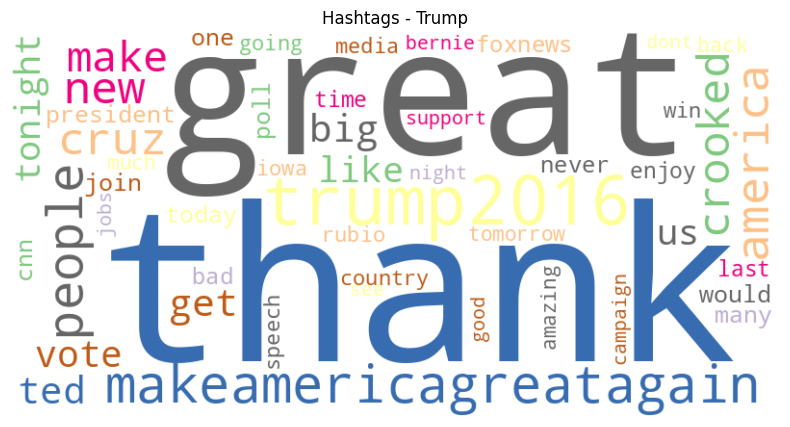

In [12]:
trump_freq50 = dict(Counter(trump_all).most_common(50))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Accent_r", random_state = 699).generate_from_frequencies(trump_freq50)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Hashtags - Trump")
plt.show()

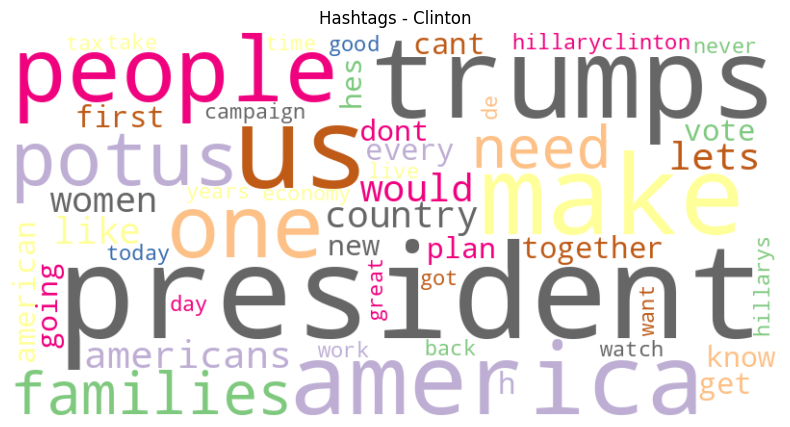

In [13]:
clinton_freq50 = dict(Counter(clinton_all).most_common(50))

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="Accent_r", random_state = 699).generate_from_frequencies(clinton_freq50)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Hashtags - Clinton")
plt.show()

### Spread and skewness comparison of sentiment scores for Trump and Clinton

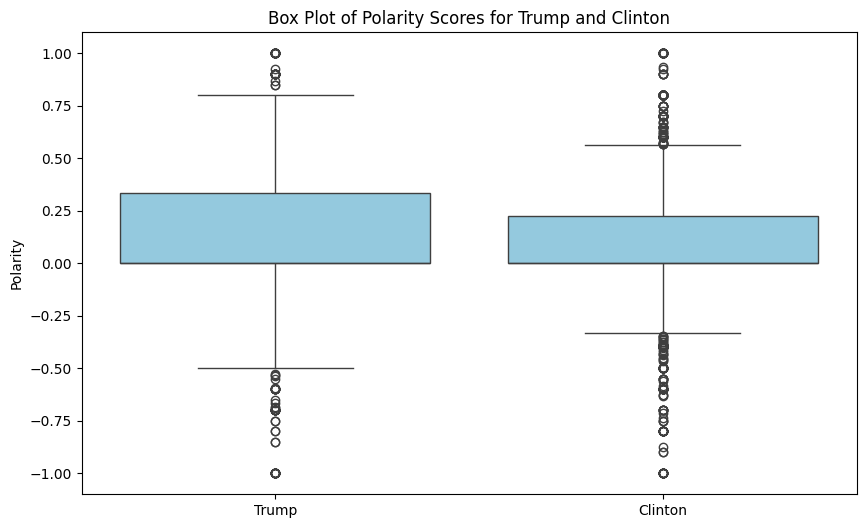

In [14]:
# Calculate polarity on preprocessed_text
trump['polarity'] = trump['preprocessed_text'].apply(lambda text: TextBlob(' '.join(text)).sentiment.polarity)
clinton['polarity'] = clinton['preprocessed_text'].apply(lambda text: TextBlob(' '.join(text)).sentiment.polarity)

# Combine the polarity scores for Trump and Clinton into a single DataFrame
combined_df = pd.concat([trump['polarity'], clinton['polarity']], axis=1)
combined_df.columns = ['Trump', 'Clinton'] 

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the box plot using Seaborn and set the color
sns.boxplot(data=combined_df, color='skyblue')

# Set the title and ylabel
plt.title('Box Plot of Polarity Scores for Trump and Clinton')
plt.ylabel('Polarity')

# Show the plot
plt.show()


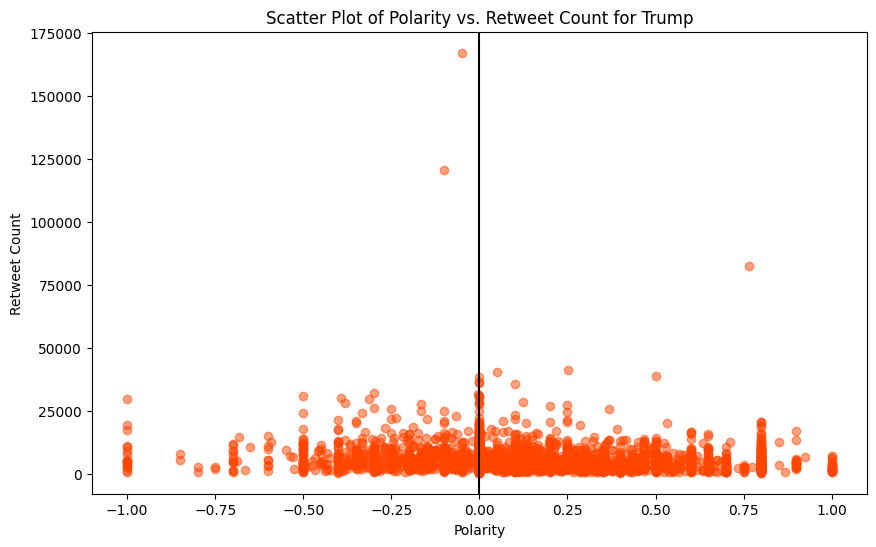

In [15]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(trump['polarity'], trump['retweet_count'], color='orangered', alpha=0.5)

# Add labels and title
plt.xlabel('Polarity')
plt.ylabel('Retweet Count')
plt.title('Scatter Plot of Polarity vs. Retweet Count for Trump')

# Add a vertical line at polarity = 0
plt.axvline(x=0, color='black')

# Show the plot
plt.show()

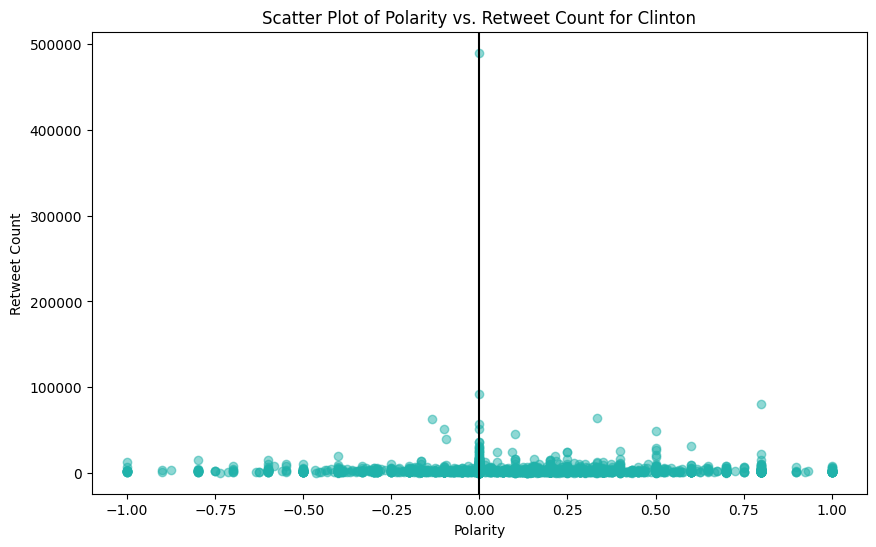

In [16]:
# Set the figure size
plt.figure(figsize=(10, 6))

# Create the scatter plot
plt.scatter(clinton['polarity'], clinton['retweet_count'], color='lightseagreen', alpha=0.5)

# Add labels and title
plt.xlabel('Polarity')
plt.ylabel('Retweet Count')
plt.title('Scatter Plot of Polarity vs. Retweet Count for Clinton')

# Add a vertical line at polarity = 0
plt.axvline(x=0, color='black')

# Show the plot
plt.show()

### Time-series comparison of ‘favorite’ tweet counts, retweet counts, and sentiment scores for Clinton and Trump 

Favorite count comparison

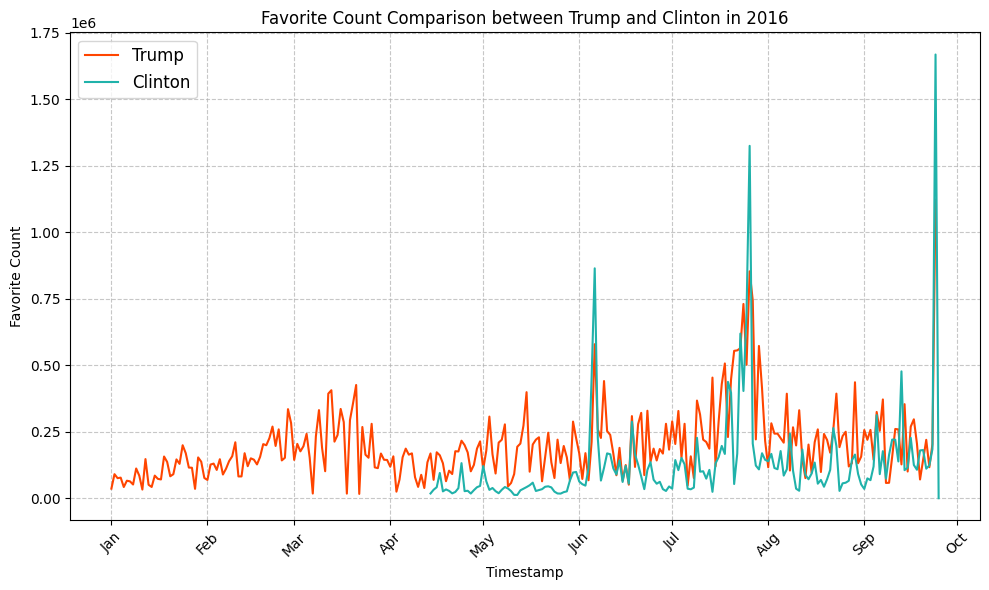

In [17]:
# Group by timestamp and calculate the sum of favorite counts for each group
trump_favorite_count = trump.groupby('date')['favorite_count'].sum().reset_index()
clinton_favorite_count = clinton.groupby('date')['favorite_count'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(trump_favorite_count.date.to_numpy(), trump_favorite_count.favorite_count.to_numpy(), label='Trump', color='orangered')
plt.plot(clinton_favorite_count.date.to_numpy(), clinton_favorite_count.favorite_count.to_numpy(), label='Clinton', color='lightseagreen')
plt.xlabel('Timestamp')
plt.ylabel('Favorite Count')
plt.title('Favorite Count Comparison between Trump and Clinton in 2016')
plt.legend(loc='upper left', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Set locator and formatter for x-axis
locator = MonthLocator(range(1, 13), bymonthday=1, interval=1)
formatter = DateFormatter("%b")
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()

Retweet count comparison

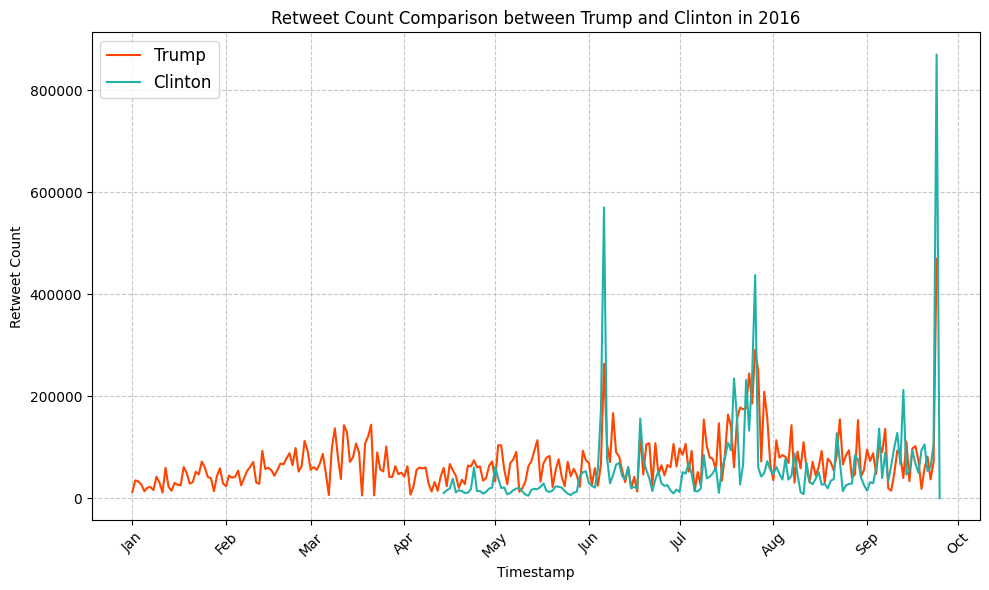

In [18]:
# Group by timestamp and calculate the sum of retweet counts for each group
trump_retweet_counts = trump.groupby('date')['retweet_count'].sum().reset_index()
clinton_retweet_counts = clinton.groupby('date')['retweet_count'].sum().reset_index()

# Plot the line chart
plt.figure(figsize=(10, 6))
plt.plot(trump_retweet_counts.date.to_numpy(), trump_retweet_counts.retweet_count.to_numpy(), label='Trump', color='orangered')
plt.plot(clinton_retweet_counts.date.to_numpy(), clinton_retweet_counts.retweet_count.to_numpy(), label='Clinton', color='lightseagreen')
plt.xlabel('Timestamp')
plt.ylabel('Retweet Count')
plt.title('Retweet Count Comparison between Trump and Clinton in 2016')
plt.legend(loc='upper left', fontsize=12)

# Add grid lines
plt.grid(True, linestyle='--', alpha=0.7)

# Set locator and formatter for x-axis
locator = MonthLocator(range(1, 13), bymonthday=1, interval=1)
formatter = DateFormatter("%b")
plt.gca().xaxis.set_major_locator(locator)
plt.gca().xaxis.set_major_formatter(formatter)

plt.xticks(rotation=45) 

plt.tight_layout()
plt.show()
